In [2]:
import scipy as sp
from scipy.io import arff
from cStringIO import StringIO
import pandas
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import sklearn.metrics.cluster as sk_cluster_m
import sklearn.metrics as skmetrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout


In [3]:
f="datasets/pen-based.arff"
data, meta = arff.loadarff(f)

In [4]:
#print meta
#print data.size
#print len(data[0])


### K-means

In [5]:
"""Function Utils"""
def rand_centroids(K, X):
    # rand_centroids(K=Int, X=Float_array):
    # Return a numpy array of size K with each element 
    # being a normally random distributed var with mu and sigma calculated 
    # from the mean and std of the data X
    mean, std = np.mean(X, axis=0), np.std(X, axis=0)
    clusters = [np.random.normal(mean, std) for n in range(K)]
    return np.array(clusters)

def euc_distance(X, Y):    
    # euc_distance(X=Float_array, Y=Float_array):
    # Returns an array of euclidean distances, 
    # for the square root of the sum of the square of the differences
    # of array X and array Y
    diff = X - Y[:, np.newaxis]
    squared_diff = diff**2
    sum_squared_diff = squared_diff.sum(axis=2)
    return np.sqrt(sum_squared_diff)

def compute_clusters(K, C, X):
    # compute_clusters(K=Int, C=Float_array, X=Float_array)
    # Compute the clusters for cluster size K, clusters C and data X
    # where a new cluster is calculated as the mean of the data points 
    # which share a common nearest cluster. Repeats until the sum of
    # the euc distances between clusters and points does not change, 
    # then returns the clusters
    D = euc_distance(X, C)
    CC = np.argmin(D, axis=0)
    C = np.array([new_cluster(k, X, CC) for k in range(K)])
    D2 = euc_distance(X, C)
    if (D.sum() == D2.sum()):
        return C, np.argmin(D2, axis=0)
    else:
        return compute_clusters(K, C, X)

def new_cluster(k, X, CC):
    # Returns a new cluster based on the mean of the points associated with it
    # if no points associated with it, generates a new one
    x = X[CC==k]
    if (len(x) > 0):
        return x.mean(axis=0)
    else: 
        return rand_centroids(1, X)[0]
    
def k_means(K, X):
    # k_means(K=Int, X=Float_array)
    # K-means for clust size K on dataset X using random initialised centroids
    # returns final clusters and predicted labels
    C = rand_centroids(K, X)
    return compute_clusters(K, C, X)

### Bisecting K-means


#### Bisecting K-means: Cost function k-means

In [99]:
def squares_dist(x):
    #squares_dist(x=ndarray):
    #x: matrix N,M. N rows of data variables. 
    #.  M/2 columns are data features values, M/2 columns are cluster centroid coord. 
    #returns square distances
    
    return (sp.spatial.distance.pdist([x[:x.shape[0]/2],x[x.shape[0]/2:]], 'euclidean'))**2


def cost_function(data_n,clusters_n, log_level=1):
    #cost_function(data_n=ndarray,clusters_n:array)
    #data_n: clustered data
    #clusters_n: clusters association in the data (size: rows of data_n, 1)
    #returns the cost function value
    print data_n.shape[1]
    #Find the centroids of each cluster 
    mus=np.array([data_n[np.where(clusters_n==k)].mean(axis=0) for k in range(len(np.unique(clusters_n)))])
    
    #vector of mu feature values of the associated cluster for each data variable
    mus_complete=np.empty([clusters_n.shape[0],data_n.shape[1]])
    
    for k in range(len(np.unique(clusters_n))):
        
        mus_complete[np.where(clusters_n==k)]=mus[k]
    
    #calculate cost function
    cost_f=sum(np.apply_along_axis(squares_dist, axis=1,arr=np.concatenate((data_n,mus_complete),axis=1))) 
    cost_f=cost_f/data_n.shape[0]
    
    if log_level:
        print "Cost function kmeans split:",cost_f
    return cost_f
                         

#### Bisecting K-means: Cluster division selection

In [90]:
def select_split_cluster(clusters, criteria="larger", log_level=1):
    #select_split_cluster (clusters, criteria)
    #clusters: vector of data cluster association (1 column)
    #criteria= "larger". (more option tbi)
    #returns de number of the selected cluster.
    
    selected_key_c=0
    number_of_x=[]
    
    if criteria == "larger":
        for i in np.nditer(np.unique(clusters)):

            number_of_x.append([len(clusters[np.where(clusters==i)]),i])
        
        selected_key_c=number_of_x[number_of_x.index(max(number_of_x))][1]
        
        if log_level:
            print "Number of x in each cluster:", number_of_x

    return selected_key_c

#### Bisecting Kmeans algorithm: MAIN

In [91]:

def Bk_means(X, K, k_means_iter=3, log_level=1):
    #Bk_means(X=ndarray, K=Int, k_means_iter=3)
    #X: data to cluster
    #K: number of clusters
    #k_means_iter: number of iteretations on the kmeans call. # of split cluster pairs.
    #log_level: 0 : no messages, 1 print messages 
    
    # Initialize cluster  assigment with all data
    clusters=np.zeros((X.shape[0],1))
    
    
    #Set initial number of cluster to 1 and iterate until number of clusters=K
    
    for k in range(1,K):
        if log_level:
            print "*********** NEW ITERATION ************* ", k
        similarity=[]
        potential_new_clusters={}

        if log_level:
            print "*********select cluster to split******"
        
        larger_cluster_index = select_split_cluster(clusters,"larger",log_level) #options: larger, heterogeny, 
        if log_level:
            print "Selected cluster: ", larger_cluster_index
        

        kmeans_data=X[np.where(clusters==larger_cluster_index),:]
        kmeans_data=kmeans_data[0]
        
        if log_level:
            print "*********Generate 2 clusters with Kmeans ******"
            print "*********Best of ", k_means_iter," results ******"
        
        for i in range(0,k_means_iter): 
        #if k_means_iter >1 then we select best k_means split with similarity 
            #potential_new_clusters[i] = KMeans(2, "random",1).fit_predict(kmeans_data)
            #potential_new_clusters[i] = KMeans(2).fit_predict(kmeans_data)
            #call to our kmeans function
            if log_level: 
                print k_means(2,kmeans_data)
            if log_level:
                print k_means(2,kmeans_data)[1].shape
            potential_new_clusters[i] = k_means(2,kmeans_data)[1]
            similarity.append(cost_function(kmeans_data,potential_new_clusters[i],log_level))
        
        #Select division based on similarity (min value max similarity)
        selected_division=potential_new_clusters[similarity.index(min(similarity))]
        
        if log_level:
            print "Selected case: ", similarity.index(min(similarity))
        
        new_clusters=selected_division
        new_clusters[np.where(selected_division==1)]=k
        new_clusters[np.where(selected_division==0)]=larger_cluster_index

        
        clusters[np.where(clusters[:]==larger_cluster_index)]=new_clusters

    if log_level:
        print "****** END OF BKmeans *********\n\n\n"    
    return clusters.flatten()



#### Bisecting K-means: Performance evaluation with Iris dataset

In [34]:

def plot_accuracies_BK(accuracies,MAX_K,MAX_K_Iter, gtitle):
    
    traces = []
    for i in range(1,MAX_K_Iter/2): 
        name1='adjusted_rand_score iter_k-means=' + str(i*2-1)
        name2='calinski_score iter_k-means=' + str(i*2-1)
        traces.append(Scatter(x=range(2, MAX_K), y=accuracies[:,4*(i-1)], name = name1))
        traces.append(Scatter(x=range(2, MAX_K), y=accuracies[:,4*i-1], name = name2, yaxis='y2'))


    yaxis2=dict(side='right')
    layout = Layout(
        title= gtitle,
        xaxis=dict(title='cluster_size'),
        yaxis=dict(title='adjusted_rand_score'),
        yaxis2=dict(title='calinski_score', overlaying='y', side='right')
    )

    fig = Figure(data=traces, layout=layout)
    plot(fig)

****** Performance evaluation with Pen BASED dataset *********



[ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
16


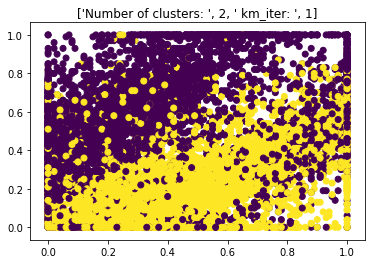

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2992.42072025



16
16


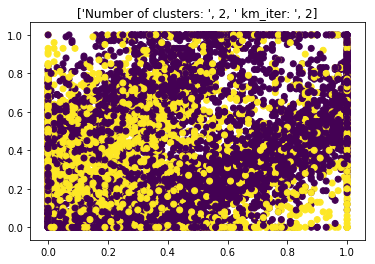

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2979.74065278



16
16
16


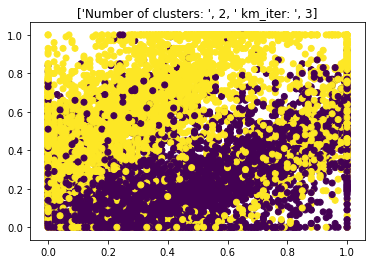

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2992.4081628



16
16
16
16


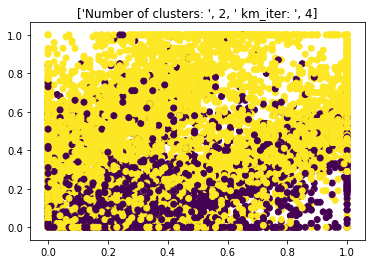

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3034.00855088



16
16


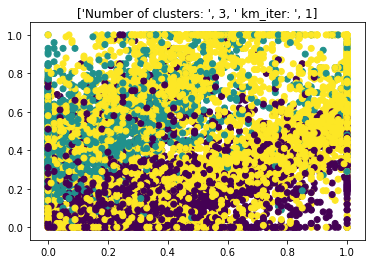

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3298.65486916



16
16
16
16


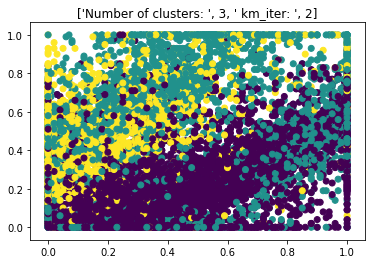

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3097.10424858



16
16
16
16
16
16


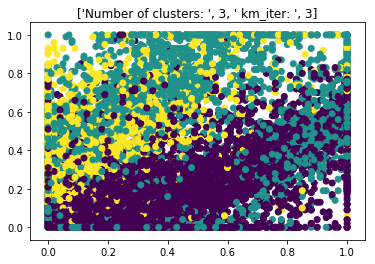

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3092.68836669



16
16
16
16
16
16
16
16


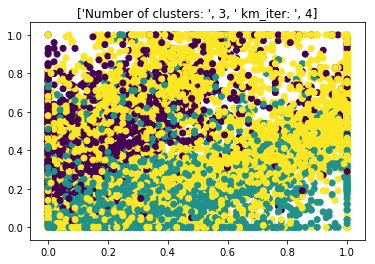

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3298.65486916



16
16
16


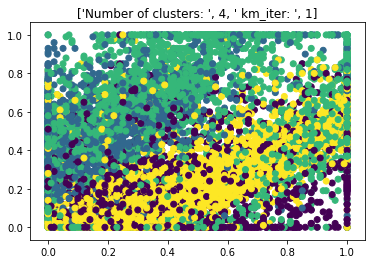

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3022.10305202



16
16
16
16
16
16


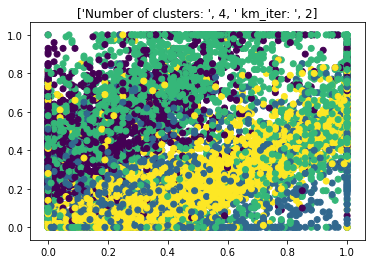

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3020.84238038



16
16
16
16
16
16
16
16
16


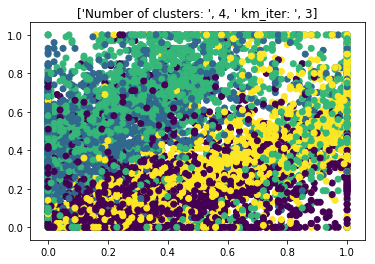

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3260.49596476



16
16
16
16
16
16
16
16
16
16
16
16


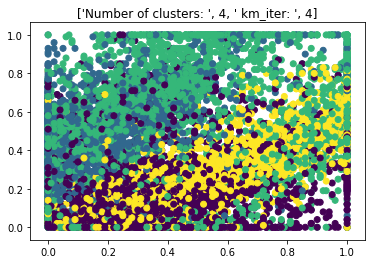

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3096.11610412



16
16
16
16


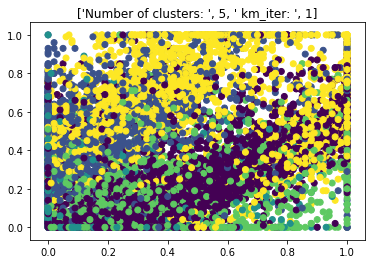

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2685.70628473



16
16
16
16
16
16
16
16


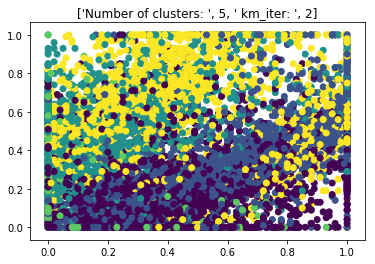

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2838.63558221



16
16
16
16
16
16
16
16
16
16
16
16


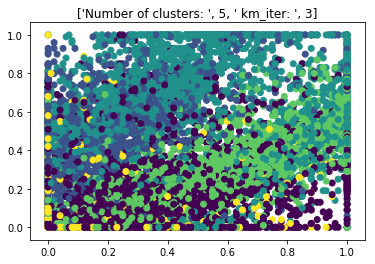

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2781.53449821



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


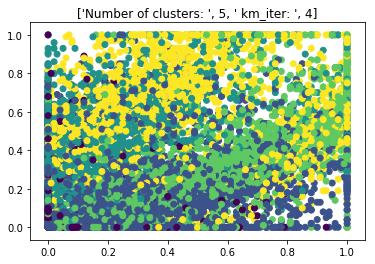

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2838.84637918



16
16
16
16
16


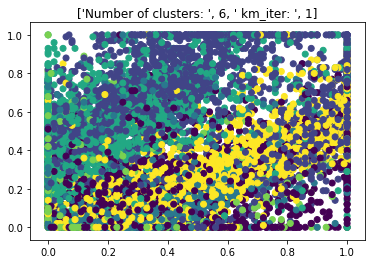

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2940.17151065



16
16
16
16
16
16
16
16
16
16


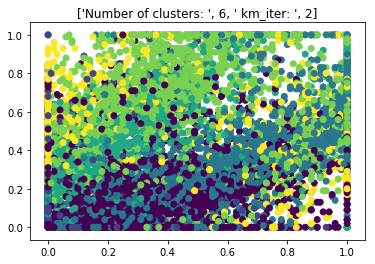

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2476.60223624



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


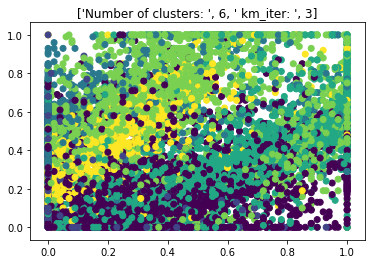

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2431.35873023



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


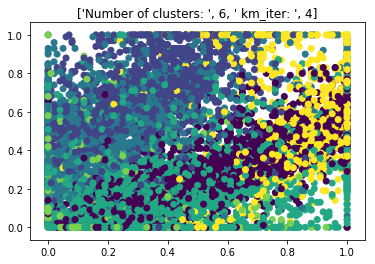

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2460.68053684



16
16
16
16
16
16


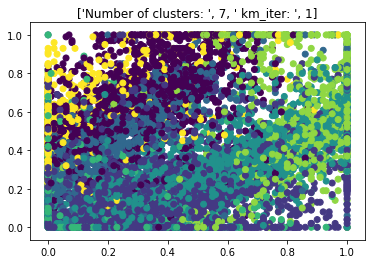

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2197.67514206



16
16
16
16
16
16
16
16
16
16
16
16


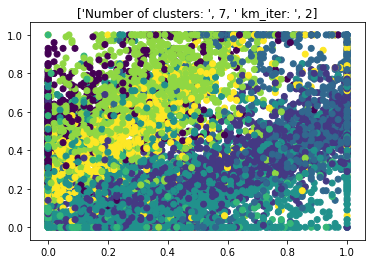

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2197.13065219



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


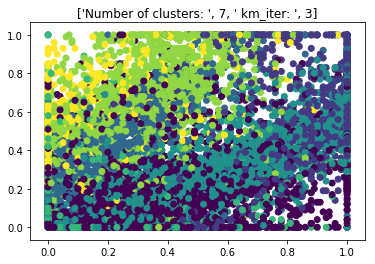

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2198.11811341



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


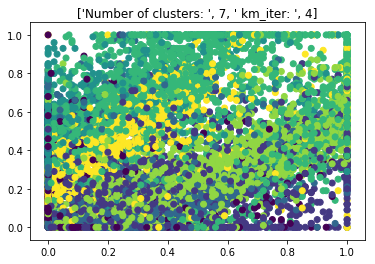

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2629.84964632



16
16
16
16
16
16
16


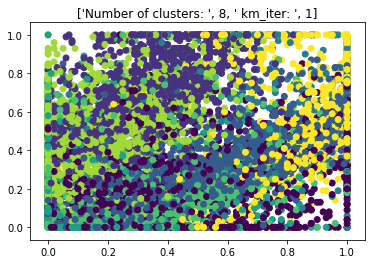

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2421.07292322



16
16
16
16
16
16
16
16
16
16
16
16
16
16


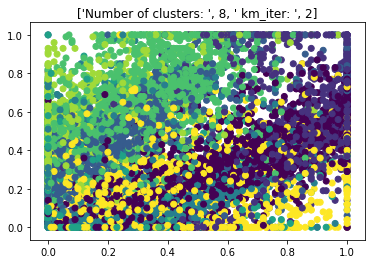

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2467.31967515



16
16
16


KeyboardInterrupt: 

In [28]:
#check results

print "****** Performance evaluation with Pen BASED dataset *********\n\n\n" 

#load dataset PEN BASED
f="datasets/pen-based.arff"
data, meta = arff.loadarff(f)

#initialize data ndarrays data_num
#. data_num to cluster 
#. data_label: ground truth classification

data_num=np.zeros((len(data), len(data[0])-1))
data_label=np.zeros((len(data)))

i=0
for d in data:
    data_num[i,:]=[d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],d[10],d[11],d[12],d[13],d[14],d[15]]
   
    data_label[i]=data[16][0]
    
                    
    i=i+1   
print data_label

######### SET max_K and max_k_iter TO PLOT Bisecting K-means results for Iris

max_k_iter=5
plt.figure()
accuracies_ar=np.zeros([max_K-2,(max_k_iter-1)*2])
max_K=10

for wanted_K in range(2,max_K):
 
    
    r_array=np.zeros((max_k_iter-1)*2)
    
    for km_iter in range(1,max_k_iter):

        cluster_assingment=Bk_means(data_num,wanted_K,km_iter,0)
        #cluster_assingment=KMeans(wanted_K).fit_predict(data_num)
        plt.title(["Number of clusters: ",wanted_K," km_iter: " , km_iter] )
        #plt.subplot(2,2,wanted_K-1)
        plt.scatter(data_num[:, 0], data_num[:, 2], c=cluster_assingment)
        #plt.text(2, 0.65, ["Adjusted rand Index: " , adjusted_rand_score(data_label.flatten(), cluster_assingment.flatten())])
        #plt.xlabel(meta[0])
        #plt.ylabel(meta[1])
        plt.show()
        rand_score = sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
        calinski = skmetrics.calinski_harabaz_score(data_num, cluster_assingment)
        r_array[2*(km_iter-1)]=rand_score
        r_array[2*km_iter-1]=calinski
        
        print "Adjusted rand Index: " , sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
        #print "V measure score: " , sk_cluster_m.v_measure_score(data_label.flatten(), cluster_assingment)
        print "Calinski Harabaz Score: ", skmetrics.calinski_harabaz_score(data_num, cluster_assingment) 
        print "\n\n"
    
    accuracies_ar[wanted_K-2,:]=r_array[:]
    


#print accuracies_ar[:][0]
plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"Bisecting K-means accuracy")


****** Performance evaluation with Iris dataset *********



4


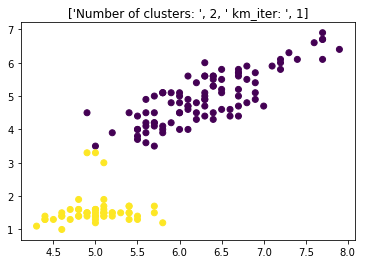

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0. 

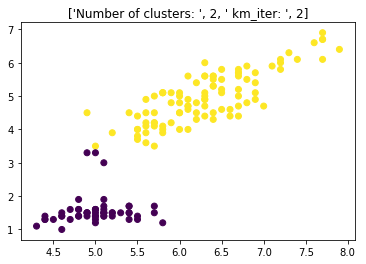

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1. 

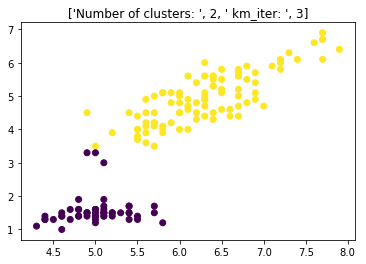

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1. 

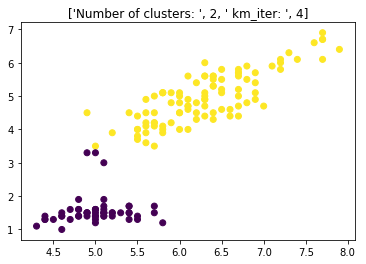

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1. 

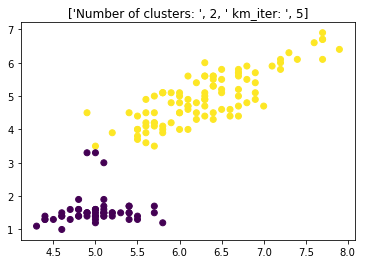

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1. 

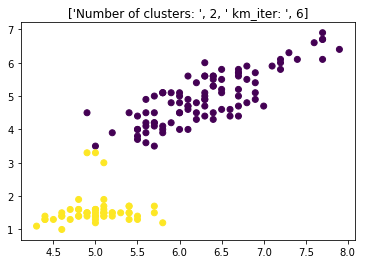

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0. 

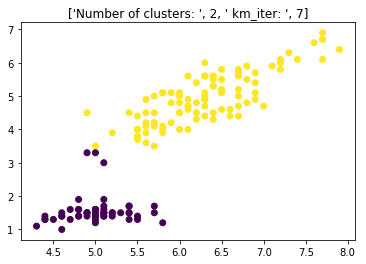

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1. 

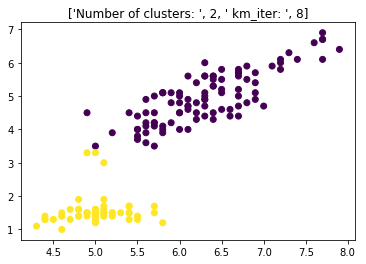

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0. 

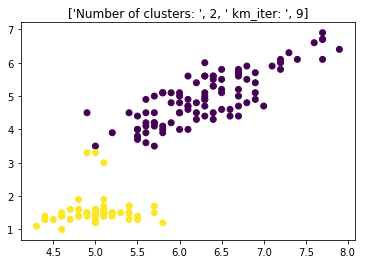

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0. 

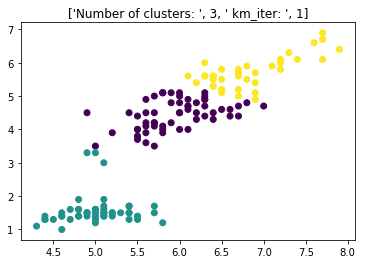

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  2.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0. 

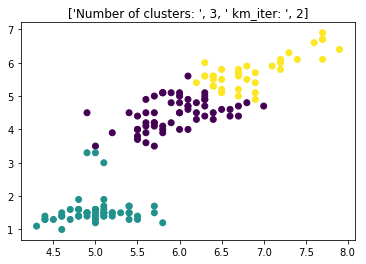

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  2.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0. 

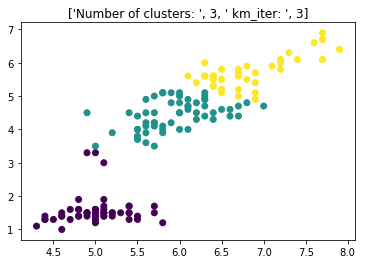

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  2.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1. 

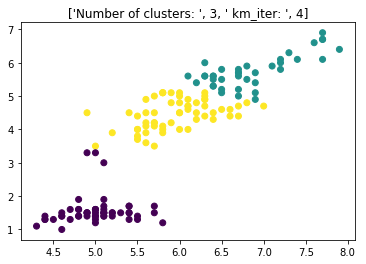

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  1.  2.
  2.  2.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  0.  2.  2. 

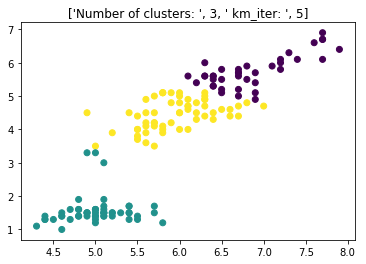

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  0.  2.
  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  1.  2.  2. 

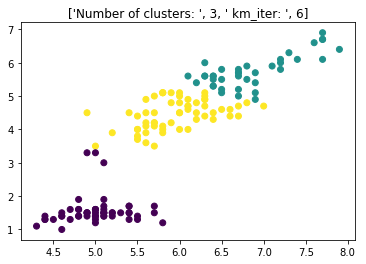

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  1.  2.
  2.  2.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  0.  2.  2. 

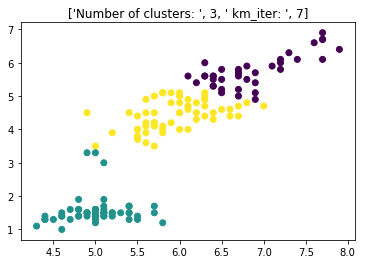

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  0.  2.
  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  1.  2.  2. 

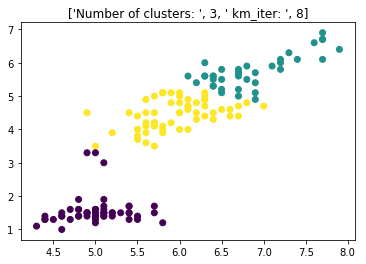

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  1.  2.
  2.  2.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  0.  2.  2. 

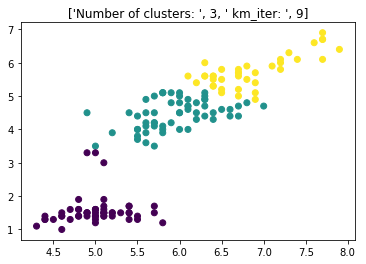

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  2.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1. 

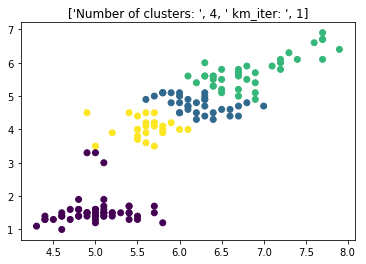

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  2.  3.
  1.  3.  1.  0.  1.  3.  3.  3.  3.  1.  3.  1.  3.  3.  1.  3.  1.  3.
  1.  1.  1.  1.  1.  2.  1.  3.  3.  3.  3.  1.  3.  1.  1.  1.  3.  3.
  3.  1.  3.  0.  3.  3. 

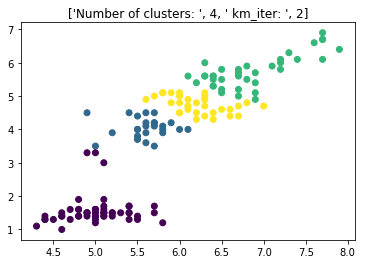

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  2.  1.
  3.  1.  3.  0.  3.  1.  1.  1.  1.  3.  1.  3.  1.  1.  3.  1.  3.  1.
  3.  3.  3.  3.  3.  2.  3.  1.  1.  1.  1.  3.  1.  3.  3.  3.  1.  1.
  1.  3.  1.  0.  1.  1. 

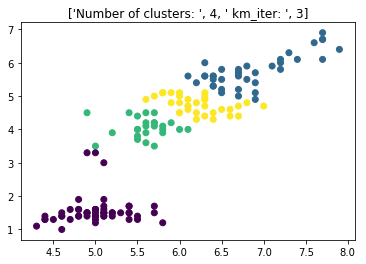

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  1.  2.
  3.  2.  3.  0.  3.  2.  2.  2.  2.  3.  2.  3.  2.  2.  3.  2.  3.  2.
  3.  3.  3.  3.  3.  1.  3.  2.  2.  2.  2.  3.  2.  3.  3.  3.  2.  2.
  2.  3.  2.  0.  2.  2. 

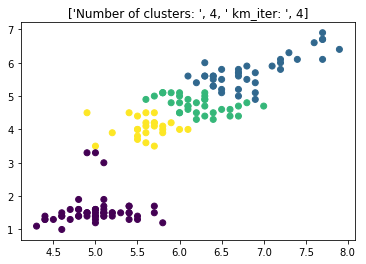

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  1.  3.
  2.  3.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  1.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  0.  3.  3. 

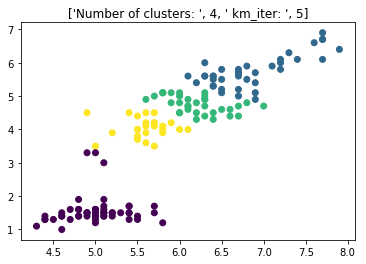

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  1.  3.
  2.  3.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  1.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  0.  3.  3. 

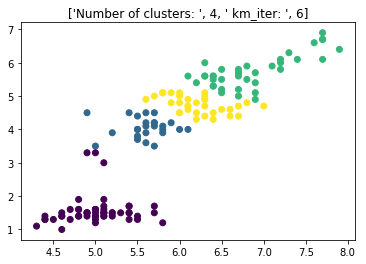

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  2.  1.
  3.  1.  3.  0.  3.  1.  1.  1.  1.  3.  1.  3.  1.  1.  3.  1.  3.  1.
  3.  3.  3.  3.  3.  2.  3.  1.  1.  1.  1.  3.  1.  3.  3.  3.  1.  1.
  1.  3.  1.  0.  1.  1. 

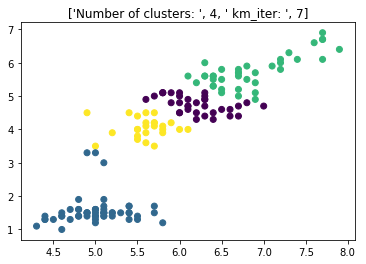

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  2.  3.
  0.  3.  0.  1.  0.  3.  3.  3.  3.  0.  3.  0.  3.  3.  0.  3.  0.  3.
  0.  0.  0.  0.  0.  2.  0.  3.  3.  3.  3.  0.  3.  0.  0.  0.  3.  3.
  3.  0.  3.  1.  3.  3. 

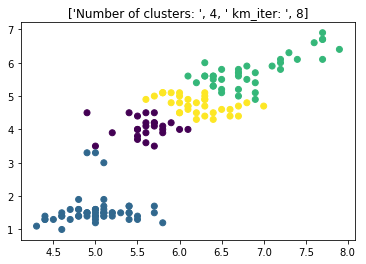

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  3.  3.  2.  0.
  3.  0.  3.  1.  3.  0.  0.  0.  0.  3.  0.  3.  0.  0.  3.  0.  3.  0.
  3.  3.  3.  3.  3.  2.  3.  0.  0.  0.  0.  3.  0.  3.  3.  3.  0.  0.
  0.  3.  0.  1.  0.  0. 

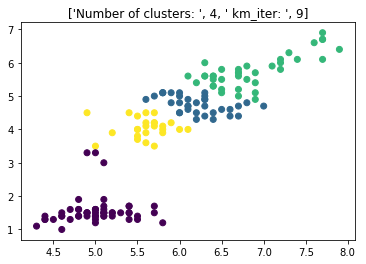

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  2.  3.
  1.  3.  1.  0.  1.  3.  3.  3.  3.  1.  3.  1.  3.  3.  1.  3.  1.  3.
  1.  1.  1.  1.  1.  2.  1.  3.  3.  3.  3.  1.  3.  1.  1.  1.  3.  3.
  3.  1.  3.  0.  3.  3. 

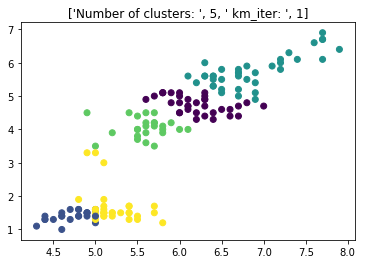

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  1.  1.  1.  4.  4.  1.  4.  1.  1.  4.  1.  1.  1.  4.  4.  4.  4.
  4.  4.  4.  4.  1.  4.  4.  1.  4.  4.  4.  1.  1.  4.  4.  4.  1.  1.
  4.  1.  1.  4.  4.  1.  1.  4.  4.  1.  4.  1.  4.  1.  0.  0.  2.  3.
  0.  3.  0.  4.  0.  3.  3.  3.  3.  0.  3.  0.  3.  3.  0.  3.  0.  3.
  0.  0.  0.  0.  0.  2.  0.  3.  3.  3.  3.  0.  3.  0.  0.  0.  3.  3.
  3.  0.  3.  4.  3.  3. 

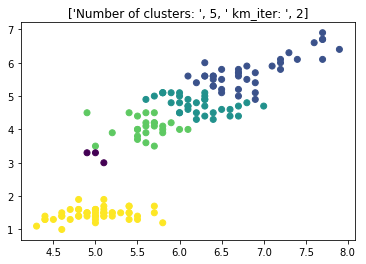

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  2.  2.  1.  3.
  2.  3.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  1.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  0.  3.  3. 

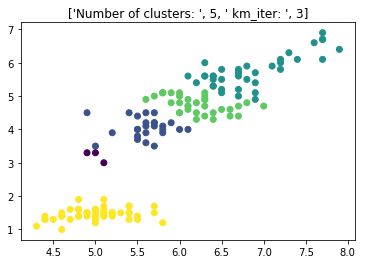

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  3.  3.  2.  1.
  3.  1.  3.  0.  3.  1.  1.  1.  1.  3.  1.  3.  1.  1.  3.  1.  3.  1.
  3.  3.  3.  3.  3.  2.  3.  1.  1.  1.  1.  3.  1.  3.  3.  3.  1.  1.
  1.  3.  1.  0.  1.  1. 

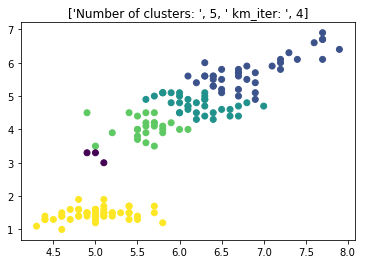

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  2.  2.  1.  3.
  2.  3.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  1.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  0.  3.  3. 

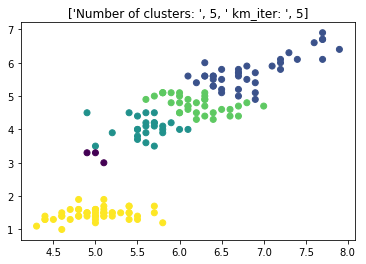

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  3.  3.  1.  2.
  3.  2.  3.  0.  3.  2.  2.  2.  2.  3.  2.  3.  2.  2.  3.  2.  3.  2.
  3.  3.  3.  3.  3.  1.  3.  2.  2.  2.  2.  3.  2.  3.  3.  3.  2.  2.
  2.  3.  2.  0.  2.  2. 

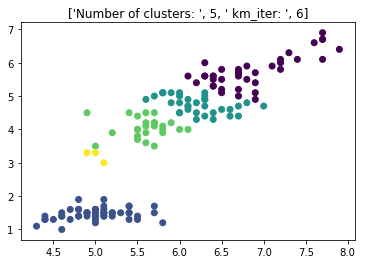

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  0.  3.
  2.  3.  2.  4.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  4.  3.  3. 

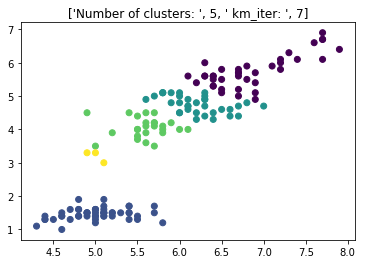

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  0.  3.
  2.  3.  2.  4.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  4.  3.  3. 

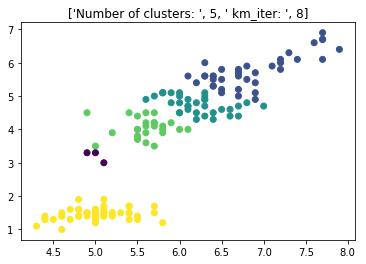

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  2.  2.  1.  3.
  2.  3.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  1.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  0.  3.  3. 

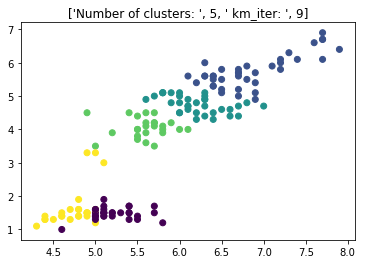

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  4.  4.  4.  0.  0.  4.  0.  4.  4.  0.  4.  4.  4.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  4.  4.  0.  0.  0.  4.  4.  0.  0.  0.  4.  4.
  0.  4.  4.  0.  0.  4.  4.  0.  0.  4.  0.  4.  0.  0.  2.  2.  1.  3.
  2.  3.  2.  4.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  1.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  4.  3.  3. 

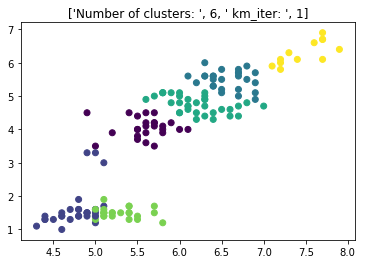

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  1.  1.  1.  4.  4.  1.  1.  1.  1.  4.  1.  1.  1.  4.  4.  4.  4.
  4.  4.  4.  4.  1.  1.  1.  1.  1.  4.  4.  1.  1.  4.  4.  4.  1.  1.
  4.  1.  1.  4.  4.  1.  1.  4.  4.  1.  4.  1.  4.  1.  3.  3.  2.  0.
  3.  0.  3.  1.  3.  0.  0.  0.  0.  3.  0.  3.  0.  0.  3.  0.  3.  0.
  3.  3.  3.  3.  3.  2.  3.  0.  0.  0.  0.  3.  0.  3.  3.  3.  0.  0.
  0.  3.  0.  1.  0.  0. 

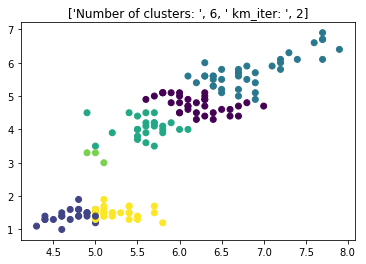

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  1.  1.  1.  5.  5.  1.  5.  1.  1.  5.  1.  1.  1.  5.  5.  5.  5.
  5.  5.  5.  5.  1.  5.  1.  1.  5.  5.  5.  1.  1.  5.  5.  5.  1.  1.
  5.  1.  1.  5.  5.  1.  1.  5.  5.  1.  5.  1.  5.  1.  0.  0.  2.  3.
  0.  3.  0.  4.  0.  3.  3.  3.  3.  0.  3.  0.  3.  3.  0.  3.  0.  3.
  0.  0.  0.  0.  0.  2.  0.  3.  3.  3.  3.  0.  3.  0.  0.  0.  3.  3.
  3.  0.  3.  4.  3.  3. 

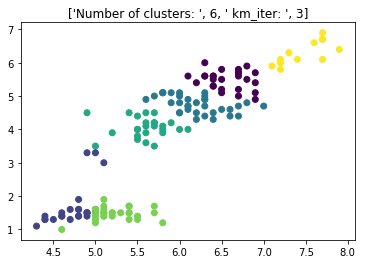

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  1.  1.  1.  4.  4.  1.  4.  1.  1.  4.  1.  1.  1.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  1.  1.  4.  4.  4.  1.  1.  4.  4.  4.  1.  4.
  4.  1.  1.  4.  4.  1.  1.  4.  4.  1.  4.  1.  4.  4.  2.  2.  0.  3.
  2.  3.  2.  1.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  1.  3.  3. 

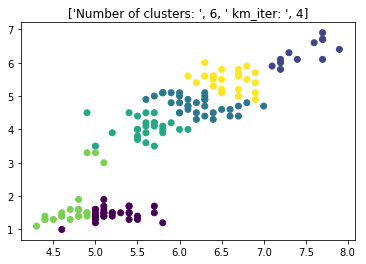

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  4.  4.  4.  0.  0.  4.  0.  4.  4.  0.  4.  4.  4.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  4.  4.  0.  0.  0.  4.  4.  0.  0.  0.  4.  0.
  0.  4.  4.  0.  0.  4.  4.  0.  0.  4.  0.  4.  0.  0.  2.  2.  5.  3.
  2.  3.  2.  4.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  5.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  4.  3.  3. 

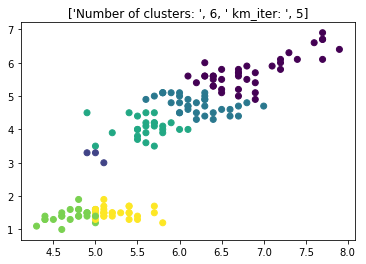

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  5.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  2.  2.  0.  3.
  2.  3.  2.  1.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  1.  3.  3. 

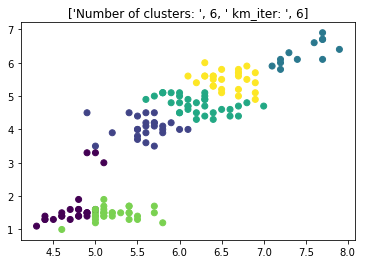

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  0.  0.  0.  4.  4.  0.  4.  0.  0.  4.  0.  0.  0.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  0.  0.  4.  4.  4.  0.  0.  4.  4.  4.  0.  4.
  4.  0.  0.  4.  4.  0.  0.  4.  4.  0.  4.  0.  4.  4.  3.  3.  5.  1.
  3.  1.  3.  0.  3.  1.  1.  1.  1.  3.  1.  3.  1.  1.  3.  1.  3.  1.
  3.  3.  3.  3.  3.  5.  3.  1.  1.  1.  1.  3.  1.  3.  3.  3.  1.  1.
  1.  3.  1.  0.  1.  1. 

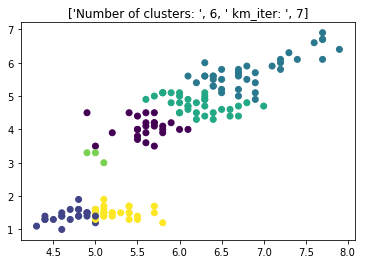

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  1.  1.  1.  5.  5.  1.  5.  1.  1.  5.  1.  1.  1.  5.  5.  5.  5.
  5.  5.  5.  5.  1.  5.  1.  1.  5.  5.  5.  1.  1.  5.  5.  5.  1.  1.
  5.  1.  1.  5.  5.  1.  1.  5.  5.  1.  5.  1.  5.  1.  3.  3.  2.  0.
  3.  0.  3.  4.  3.  0.  0.  0.  0.  3.  0.  3.  0.  0.  3.  0.  3.  0.
  3.  3.  3.  3.  3.  2.  3.  0.  0.  0.  0.  3.  0.  3.  3.  3.  0.  0.
  0.  3.  0.  4.  0.  0. 

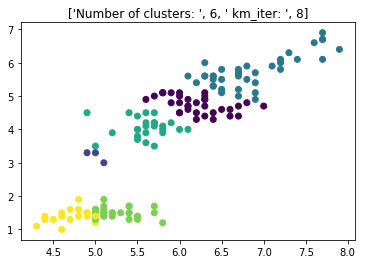

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  5.  5.  5.  4.  4.  5.  4.  5.  5.  4.  5.  5.  5.  4.  4.  4.  4.
  4.  4.  4.  4.  5.  4.  5.  5.  4.  4.  4.  5.  5.  4.  4.  4.  5.  5.
  4.  5.  5.  4.  4.  5.  5.  4.  4.  5.  4.  5.  4.  5.  0.  0.  2.  3.
  0.  3.  0.  1.  0.  3.  3.  3.  3.  0.  3.  0.  3.  3.  0.  3.  0.  3.
  0.  0.  0.  0.  0.  2.  0.  3.  3.  3.  3.  0.  3.  0.  0.  0.  3.  3.
  3.  0.  3.  1.  3.  3. 

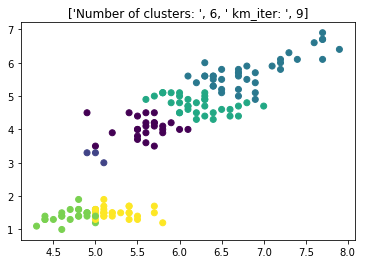

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  5.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  3.  3.  2.  0.
  3.  0.  3.  1.  3.  0.  0.  0.  0.  3.  0.  3.  0.  0.  3.  0.  3.  0.
  3.  3.  3.  3.  3.  2.  3.  0.  0.  0.  0.  3.  0.  3.  3.  3.  0.  0.
  0.  3.  0.  1.  0.  0. 

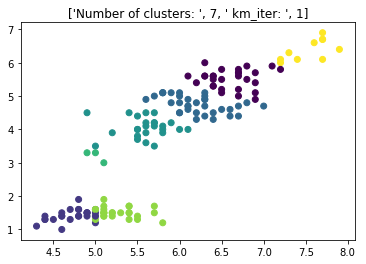

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  1.  1.  1.  5.  5.  1.  1.  1.  1.  5.  1.  1.  1.  5.  5.  5.  5.
  5.  5.  5.  5.  1.  5.  1.  1.  5.  5.  5.  1.  1.  5.  5.  5.  1.  1.
  5.  1.  1.  5.  5.  1.  1.  5.  5.  1.  5.  1.  5.  1.  2.  2.  0.  3.
  2.  3.  2.  4.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  2.  3.  2.  3.
  2.  2.  2.  2.  2.  0.  2.  3.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  4.  3.  3. 

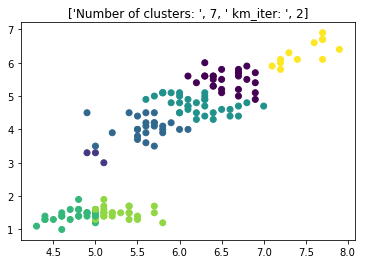

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  4.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  3.  3.  0.  2.
  3.  2.  3.  1.  3.  2.  2.  2.  2.  3.  2.  3.  2.  2.  3.  2.  3.  2.
  3.  3.  3.  3.  3.  0.  3.  2.  2.  2.  2.  3.  2.  3.  3.  3.  2.  2.
  2.  3.  2.  1.  2.  2. 

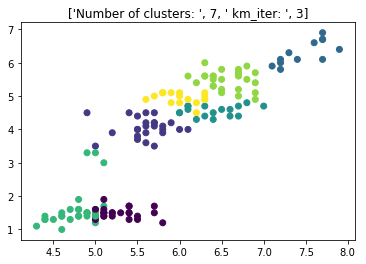

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  4.  4.  4.  0.  0.  4.  4.  4.  4.  0.  4.  4.  4.  0.  0.  0.  0.
  0.  0.  0.  0.  4.  4.  4.  4.  4.  0.  0.  4.  4.  0.  0.  0.  4.  4.
  0.  4.  4.  0.  0.  4.  4.  0.  0.  4.  0.  4.  0.  4.  3.  3.  5.  1.
  3.  1.  3.  4.  3.  1.  1.  1.  1.  3.  1.  3.  1.  1.  6.  1.  6.  1.
  6.  3.  3.  3.  3.  5.  3.  1.  1.  1.  1.  6.  1.  3.  3.  3.  1.  1.
  1.  3.  1.  4.  1.  1. 

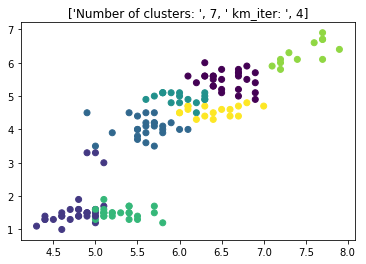

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  1.  1.  1.  4.  4.  1.  1.  1.  1.  4.  1.  1.  1.  4.  4.  4.  4.
  4.  4.  4.  4.  1.  1.  1.  1.  1.  4.  4.  1.  1.  4.  4.  4.  1.  1.
  4.  1.  1.  4.  4.  1.  1.  4.  4.  1.  4.  1.  4.  1.  6.  6.  0.  2.
  6.  2.  6.  1.  6.  2.  2.  2.  2.  6.  2.  6.  2.  2.  3.  2.  3.  2.
  3.  6.  6.  6.  6.  0.  6.  2.  2.  2.  2.  3.  2.  6.  6.  6.  2.  2.
  2.  6.  2.  1.  2.  2. 

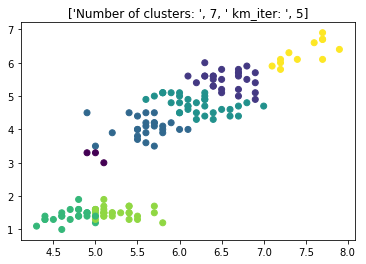

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  5.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  3.  3.  1.  2.
  3.  2.  3.  0.  3.  2.  2.  2.  2.  3.  2.  3.  2.  2.  3.  2.  3.  2.
  3.  3.  3.  3.  3.  1.  3.  2.  2.  2.  2.  3.  2.  3.  3.  3.  2.  2.
  2.  3.  2.  0.  2.  2. 

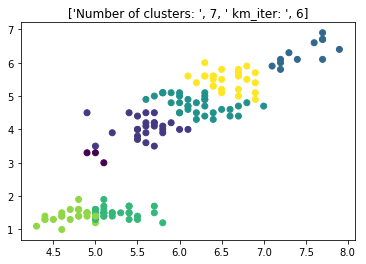

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  5.  5.  5.  4.  4.  5.  4.  5.  5.  4.  5.  5.  5.  4.  4.  4.  4.
  4.  4.  4.  4.  5.  4.  5.  5.  4.  4.  4.  5.  5.  4.  4.  4.  5.  5.
  4.  5.  5.  4.  4.  5.  5.  4.  4.  5.  4.  5.  4.  5.  3.  3.  6.  1.
  3.  1.  3.  0.  3.  1.  1.  1.  1.  3.  1.  3.  1.  1.  3.  1.  3.  1.
  3.  3.  3.  3.  3.  6.  3.  1.  1.  1.  1.  3.  1.  3.  3.  3.  1.  1.
  1.  3.  1.  0.  1.  1. 

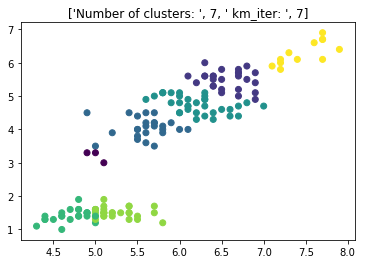

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  5.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  3.  3.  1.  2.
  3.  2.  3.  0.  3.  2.  2.  2.  2.  3.  2.  3.  2.  2.  3.  2.  3.  2.
  3.  3.  3.  3.  3.  1.  3.  2.  2.  2.  2.  3.  2.  3.  3.  3.  2.  2.
  2.  3.  2.  0.  2.  2. 

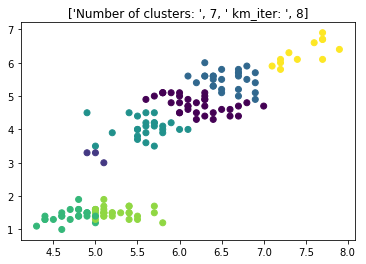

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  5.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  0.  0.  2.  3.
  0.  3.  0.  1.  0.  3.  3.  3.  3.  0.  3.  0.  3.  3.  0.  3.  0.  3.
  0.  0.  0.  0.  0.  2.  0.  3.  3.  3.  3.  0.  3.  0.  0.  0.  3.  3.
  3.  0.  3.  1.  3.  3. 

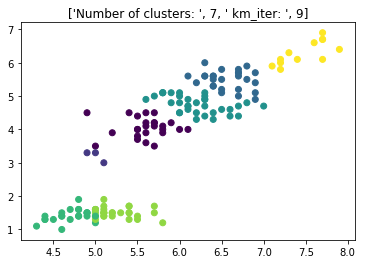

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  5.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  3.  3.  2.  0.
  3.  0.  3.  1.  3.  0.  0.  0.  0.  3.  0.  3.  0.  0.  3.  0.  3.  0.
  3.  3.  3.  3.  3.  2.  3.  0.  0.  0.  0.  3.  0.  3.  3.  3.  0.  0.
  0.  3.  0.  1.  0.  0. 

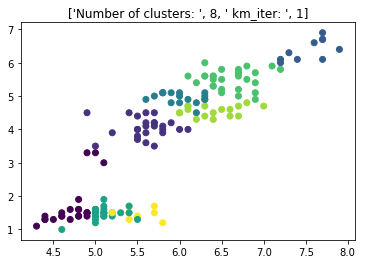

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  0.  0.  0.  4.  7.  0.  4.  0.  0.  7.  0.  0.  0.  7.  7.  7.  4.
  7.  4.  4.  4.  4.  4.  0.  0.  4.  4.  4.  0.  0.  4.  7.  7.  0.  4.
  4.  0.  0.  4.  4.  0.  0.  4.  4.  0.  4.  0.  4.  4.  6.  6.  5.  1.
  6.  1.  6.  0.  6.  1.  1.  1.  1.  6.  1.  6.  1.  1.  3.  1.  3.  1.
  3.  6.  6.  6.  6.  5.  6.  1.  1.  1.  1.  3.  1.  6.  6.  6.  1.  1.
  1.  6.  1.  0.  1.  1. 

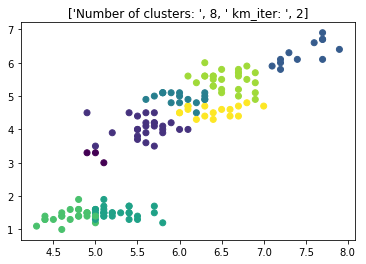

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  5.  5.  5.  4.  4.  5.  4.  5.  5.  4.  5.  5.  5.  4.  4.  4.  4.
  4.  4.  4.  4.  5.  4.  5.  5.  4.  4.  4.  5.  5.  4.  4.  4.  5.  5.
  4.  5.  5.  4.  4.  5.  5.  4.  4.  5.  4.  5.  4.  5.  7.  7.  6.  1.
  7.  1.  7.  0.  7.  1.  1.  1.  1.  7.  1.  7.  1.  1.  3.  1.  3.  1.
  3.  7.  7.  7.  7.  6.  7.  1.  1.  1.  1.  3.  1.  7.  7.  7.  1.  1.
  1.  7.  1.  0.  1.  1. 

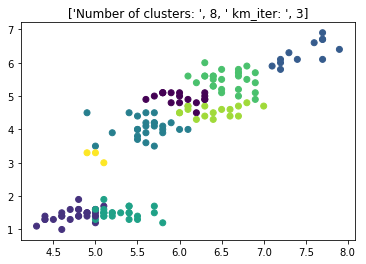

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  1.  1.  1.  4.  4.  1.  1.  1.  1.  4.  1.  1.  1.  4.  4.  4.  4.
  4.  4.  4.  4.  1.  1.  1.  1.  1.  4.  4.  1.  1.  4.  4.  4.  1.  1.
  4.  1.  1.  4.  4.  1.  1.  4.  4.  1.  4.  1.  4.  1.  6.  6.  5.  3.
  6.  3.  6.  7.  6.  3.  3.  3.  3.  6.  3.  6.  3.  3.  0.  3.  0.  3.
  0.  6.  6.  6.  6.  5.  6.  3.  3.  3.  3.  0.  3.  6.  6.  6.  3.  3.
  3.  6.  3.  7.  3.  3. 

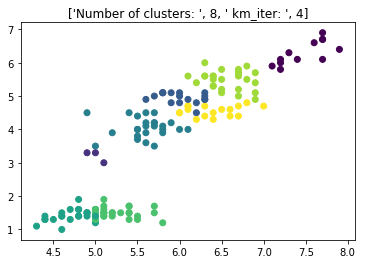

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  5.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  7.  7.  6.  3.
  7.  3.  7.  1.  7.  3.  3.  3.  3.  7.  3.  7.  3.  3.  2.  3.  2.  3.
  2.  7.  7.  7.  7.  6.  7.  3.  3.  3.  3.  2.  3.  7.  7.  7.  3.  3.
  3.  7.  3.  1.  3.  3. 

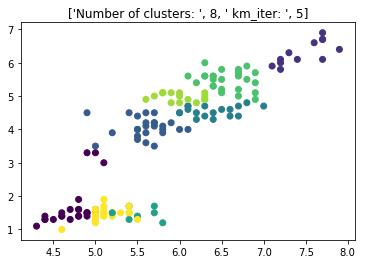

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 7.  0.  0.  0.  7.  4.  0.  7.  0.  0.  7.  0.  0.  0.  4.  4.  4.  7.
  4.  7.  7.  7.  7.  7.  0.  0.  7.  7.  7.  0.  0.  7.  4.  4.  0.  7.
  7.  0.  0.  7.  7.  0.  0.  7.  7.  0.  7.  0.  7.  7.  3.  3.  5.  2.
  3.  2.  3.  0.  3.  2.  2.  2.  2.  3.  2.  3.  2.  2.  3.  2.  6.  2.
  6.  3.  3.  3.  3.  5.  3.  2.  2.  2.  2.  6.  2.  3.  3.  3.  2.  2.
  2.  3.  2.  0.  2.  2. 

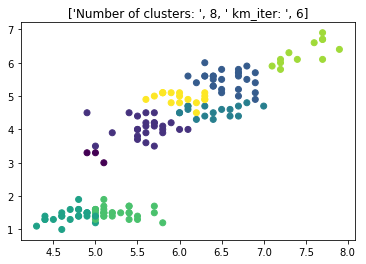

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  5.  4.  5.  4.  4.  5.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  5.  5.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  3.  3.  2.  1.
  3.  1.  3.  0.  3.  1.  1.  1.  1.  3.  1.  3.  1.  1.  7.  1.  7.  1.
  7.  3.  3.  3.  3.  2.  3.  1.  1.  1.  1.  7.  1.  3.  3.  3.  1.  1.
  1.  3.  1.  0.  1.  1. 

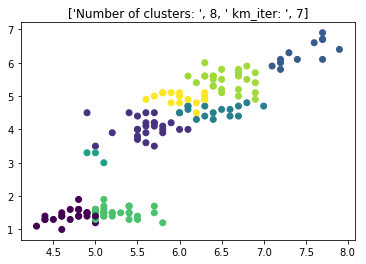

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  0.  0.  0.  5.  5.  0.  5.  0.  0.  5.  0.  0.  0.  5.  5.  5.  5.
  5.  5.  5.  5.  0.  5.  0.  0.  5.  5.  5.  0.  0.  5.  5.  5.  0.  0.
  5.  0.  0.  5.  5.  0.  0.  5.  5.  0.  5.  0.  5.  0.  3.  3.  6.  1.
  3.  1.  3.  4.  3.  1.  1.  1.  1.  3.  1.  3.  1.  1.  7.  1.  7.  1.
  7.  3.  3.  3.  3.  6.  3.  1.  1.  1.  1.  7.  1.  3.  3.  3.  1.  1.
  1.  3.  1.  4.  1.  1. 

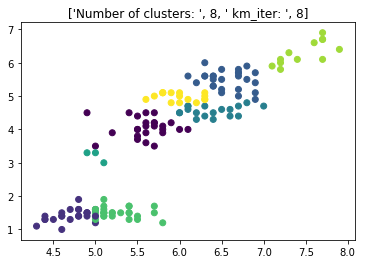

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  1.  1.  1.  5.  5.  1.  5.  1.  1.  5.  1.  1.  1.  5.  5.  5.  5.
  5.  5.  5.  5.  1.  5.  1.  1.  5.  5.  5.  1.  1.  5.  5.  5.  1.  1.
  5.  1.  1.  5.  5.  1.  1.  5.  5.  1.  5.  1.  5.  1.  3.  3.  2.  0.
  3.  0.  3.  4.  3.  0.  0.  0.  0.  3.  0.  3.  0.  0.  3.  0.  7.  0.
  7.  3.  3.  3.  3.  2.  3.  0.  0.  0.  0.  7.  0.  3.  3.  3.  0.  0.
  0.  3.  0.  4.  0.  0. 

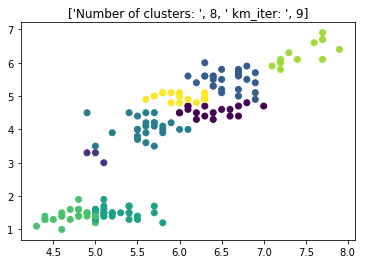

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 4.  5.  5.  5.  4.  4.  5.  4.  5.  5.  4.  5.  5.  5.  4.  4.  4.  4.
  4.  4.  4.  4.  5.  4.  5.  5.  4.  4.  4.  5.  5.  4.  4.  4.  5.  5.
  4.  5.  5.  4.  4.  5.  5.  4.  4.  5.  4.  5.  4.  5.  0.  0.  2.  3.
  0.  3.  0.  1.  0.  3.  3.  3.  3.  0.  3.  0.  3.  3.  0.  3.  7.  3.
  7.  0.  0.  0.  0.  2.  0.  3.  3.  3.  3.  7.  3.  0.  0.  0.  3.  3.
  3.  0.  3.  1.  3.  3. 

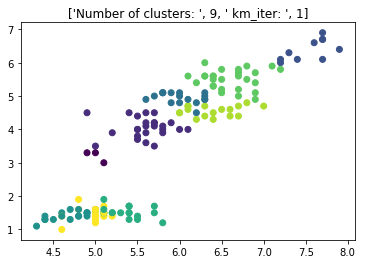

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 8.  4.  4.  4.  8.  5.  8.  8.  4.  4.  5.  8.  4.  4.  5.  5.  5.  8.
  5.  5.  5.  5.  8.  8.  8.  4.  8.  5.  8.  4.  4.  5.  5.  5.  4.  8.
  5.  4.  4.  8.  8.  4.  4.  8.  5.  4.  5.  4.  5.  8.  7.  7.  6.  1.
  7.  1.  7.  0.  7.  1.  1.  1.  1.  7.  1.  7.  1.  1.  3.  1.  3.  1.
  3.  7.  7.  7.  7.  6.  7.  1.  1.  1.  1.  3.  1.  7.  7.  7.  1.  1.
  1.  7.  1.  0.  1.  1. 

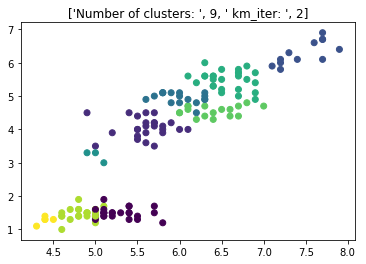

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 0.  7.  7.  7.  0.  0.  7.  7.  8.  7.  0.  7.  7.  8.  0.  0.  0.  0.
  0.  0.  0.  0.  7.  7.  7.  7.  7.  0.  0.  7.  7.  0.  0.  0.  7.  7.
  0.  7.  8.  0.  0.  8.  8.  0.  0.  7.  0.  7.  0.  7.  6.  6.  5.  1.
  6.  1.  6.  4.  6.  1.  1.  1.  1.  6.  1.  6.  1.  1.  3.  1.  3.  1.
  3.  6.  6.  6.  6.  5.  6.  1.  1.  1.  1.  3.  1.  6.  6.  6.  1.  1.
  1.  6.  1.  4.  1.  1. 

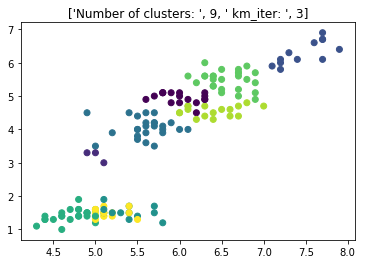

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 8.  5.  5.  5.  8.  4.  5.  8.  5.  5.  4.  5.  5.  5.  4.  4.  4.  8.
  4.  4.  8.  8.  5.  8.  5.  5.  8.  8.  8.  5.  5.  8.  4.  4.  5.  5.
  8.  5.  5.  8.  8.  5.  5.  8.  4.  5.  4.  5.  4.  5.  7.  7.  6.  3.
  7.  3.  7.  1.  7.  3.  3.  3.  3.  7.  3.  7.  3.  3.  0.  3.  0.  3.
  0.  7.  7.  7.  7.  6.  7.  3.  3.  3.  3.  0.  3.  7.  7.  7.  3.  3.
  3.  7.  3.  1.  3.  3. 

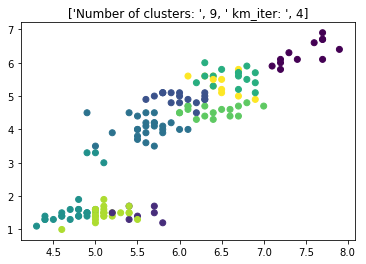

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 7.  4.  4.  4.  7.  1.  4.  7.  4.  4.  7.  4.  4.  4.  1.  1.  1.  7.
  1.  7.  7.  7.  7.  7.  4.  4.  7.  7.  7.  4.  4.  7.  1.  1.  4.  7.
  7.  4.  4.  7.  7.  4.  4.  7.  7.  4.  7.  4.  7.  7.  6.  6.  8.  3.
  6.  3.  6.  4.  6.  3.  3.  3.  3.  6.  3.  6.  3.  3.  2.  3.  2.  3.
  2.  6.  6.  6.  6.  8.  6.  3.  3.  3.  3.  2.  3.  6.  6.  6.  3.  3.
  3.  6.  3.  4.  3.  3. 

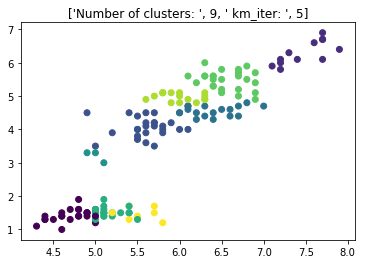

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  0.  0.  0.  5.  8.  0.  5.  0.  0.  5.  0.  0.  0.  8.  8.  8.  5.
  8.  5.  5.  5.  0.  5.  0.  0.  5.  5.  5.  0.  0.  5.  8.  8.  0.  0.
  5.  0.  0.  5.  5.  0.  0.  5.  5.  0.  5.  0.  5.  0.  3.  3.  6.  2.
  3.  2.  3.  4.  3.  2.  2.  2.  2.  3.  2.  3.  2.  2.  3.  2.  7.  2.
  7.  3.  3.  3.  3.  6.  3.  2.  2.  2.  2.  7.  2.  3.  3.  3.  2.  2.
  2.  3.  2.  4.  2.  2. 

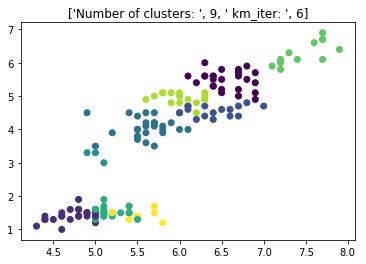

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  1.  1.  1.  5.  8.  1.  1.  1.  1.  5.  1.  1.  1.  8.  8.  8.  5.
  8.  5.  5.  5.  1.  5.  1.  1.  5.  5.  5.  1.  1.  5.  8.  8.  1.  1.
  5.  1.  1.  5.  5.  1.  1.  5.  5.  1.  5.  1.  5.  1.  2.  2.  0.  3.
  2.  3.  2.  4.  2.  3.  3.  3.  3.  2.  3.  2.  3.  3.  7.  3.  7.  3.
  7.  2.  2.  2.  2.  0.  2.  3.  3.  3.  3.  7.  3.  2.  2.  2.  3.  3.
  3.  2.  3.  4.  3.  3. 

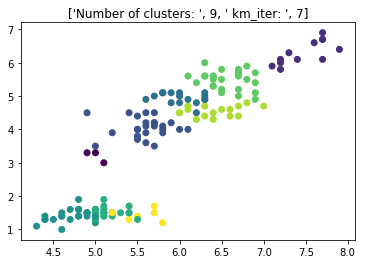

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  8.  4.  5.  4.  4.  5.  4.  4.  4.  8.  8.  8.  5.
  8.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  8.  8.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  7.  7.  6.  2.
  7.  2.  7.  0.  7.  2.  2.  2.  2.  7.  2.  7.  2.  2.  3.  2.  3.  2.
  3.  7.  7.  7.  7.  6.  7.  2.  2.  2.  2.  3.  2.  7.  7.  7.  2.  2.
  2.  7.  2.  0.  2.  2. 

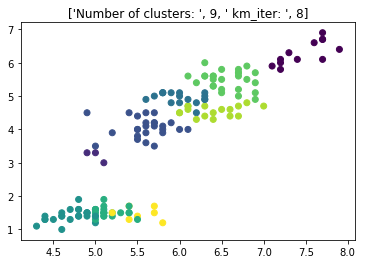

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  4.  4.  4.  5.  8.  4.  5.  4.  4.  5.  4.  4.  4.  8.  8.  8.  5.
  8.  5.  5.  5.  4.  5.  4.  4.  5.  5.  5.  4.  4.  5.  8.  8.  4.  4.
  5.  4.  4.  5.  5.  4.  4.  5.  5.  4.  5.  4.  5.  4.  7.  7.  6.  2.
  7.  2.  7.  1.  7.  2.  2.  2.  2.  7.  2.  7.  2.  2.  3.  2.  3.  2.
  3.  7.  7.  7.  7.  6.  7.  2.  2.  2.  2.  3.  2.  7.  7.  7.  2.  2.
  2.  7.  2.  1.  2.  2. 

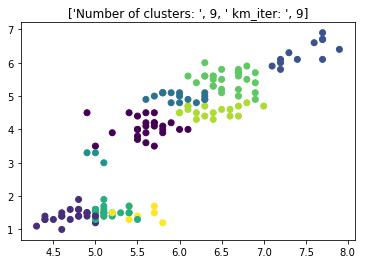

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
[ 5.  1.  1.  1.  5.  8.  1.  5.  1.  1.  5.  1.  1.  1.  8.  8.  8.  5.
  8.  5.  5.  5.  1.  5.  1.  1.  5.  5.  5.  1.  1.  5.  8.  8.  1.  1.
  5.  1.  1.  5.  5.  1.  1.  5.  5.  1.  5.  1.  5.  1.  7.  7.  6.  0.
  7.  0.  7.  4.  7.  0.  0.  0.  0.  7.  0.  7.  0.  0.  7.  0.  3.  0.
  3.  7.  7.  7.  7.  6.  7.  0.  0.  0.  0.  3.  0.  7.  7.  7.  0.  0.
  0.  7.  0.  4.  0.  0. 

In [35]:
#check results

print "****** Performance evaluation with Iris dataset *********\n\n\n" 

#load dataset IRIS
f="datasets/iris.arff"
data, meta = arff.loadarff(f)

#initialize data ndarrays data_num
#. data_num to cluster 
#. data_label: ground truth classification

data_num=np.zeros((len(data), len(data[0])-1))
data_label=np.zeros((len(data)))

i=0
for d in data:
    data_num[i,:]=[d[0],d[1],d[2],d[3]]
    if d[4]=="Iris-setosa":
        data_label[i]=0
    if d[4]=="Iris-versicolor":
        data_label[i]=1
    if d[4]=="Iris-virginica":
        data_label[i]=2
                    
    i=i+1   


######### SET max_K and max_k_iter TO PLOT Bisecting K-means results for Iris

max_k_iter=10
plt.figure()
accuracies_ar=np.zeros([max_K-2,(max_k_iter-1)*2])
max_K=10

for wanted_K in range(2,max_K):
 
    
    r_array=np.zeros((max_k_iter-1)*2)
    
    for km_iter in range(1,max_k_iter):

        cluster_assingment=Bk_means(data_num,wanted_K,km_iter,0)
        #cluster_assingment=KMeans(wanted_K).fit_predict(data_num)
        plt.title(["Number of clusters: ",wanted_K," km_iter: " , km_iter] )
        #plt.subplot(2,2,wanted_K-1)
        plt.scatter(data_num[:, 0], data_num[:, 2], c=cluster_assingment)
        #plt.text(2, 0.65, ["Adjusted rand Index: " , adjusted_rand_score(data_label.flatten(), cluster_assingment.flatten())])
        #plt.xlabel(meta[0])
        #plt.ylabel(meta[1])
        plt.show()
        rand_score = sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
        print data_label.flatten()
        print cluster_assingment
        calinski = skmetrics.calinski_harabaz_score(data_num, cluster_assingment)
        r_array[2*(km_iter-1)]=rand_score
        r_array[2*km_iter-1]=calinski
        
        print "Adjusted rand Index: " , sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
        #print "V measure score: " , sk_cluster_m.v_measure_score(data_label.flatten(), cluster_assingment)
        print "Calinski Harabaz Score: ", skmetrics.calinski_harabaz_score(data_num, cluster_assingment) 
        print "\n\n"
    
    accuracies_ar[wanted_K-2,:]=r_array[:]
    


#print accuracies_ar[:][0]
plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"Bisecting K-means accuracy")




#### Bisecting Kmeans: Compare algorithm performance to ground truth K=3 (IRIS)


In [22]:

d_Iris_setosa=data_num[np.where(data["class"]=="Iris-setosa")]
d_Iris_versicolor=data_num[np.where(data["class"]=="Iris-versicolor")]
d_Iris_virginica=data_num[np.where(data["class"]=="Iris-virginica")]

cluster_assingment=Bk_means(data_num,2,2,0)

results_c1=data_num[np.where(cluster_assingment[:]==0),:][0]
results_c2=data_num[np.where(cluster_assingment[:]==1),:][0]
results_c3=data_num[np.where(cluster_assingment[:]==2),:][0]


print len(results_c1), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, list(results_c1)))
d=len(sett)
print"Intersection of C1 with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1 with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1  with Iris virgini ",d

print "************************************* \n"

print len(results_c2), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with Iris virgini ",d

print "************************************* "

print len(results_c3), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with Iris virgini ",d



4
4
97 entries were classified in one cluster of which:

Intersection of C1 with Iris setosa  0
Intersection of C1 with Iris versicolor  47
Intersection of C1  with Iris virgini  49
************************************* 

53 entries were classified in one cluster of which:

intersection of C2 with Iris setosa  48
intersection of C2 with Iris versicolor  3
intersection of C2 with Iris virgini  0
************************************* 
0 entries were classified in one cluster of which:

intersection of C3 with Iris setosa  0
intersection of C3 with Iris versicolor  0
intersection of C3 with Iris virgini  0


[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  2.]
 [ 1.  1.  1.  3.]
 ..., 
 [ 5.  5.  5.  3.]
 [ 5.  5.  5.  4.]
 [ 5.  5.  5.  5.]]
balance data classified as L 288
balance data classified as R 288
balance data classified as B 49


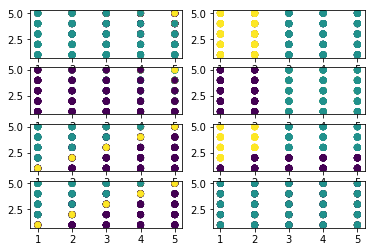

225 entries were classified in one cluster of which:



TypeError: 'numpy.float64' object is not iterable

In [27]:
balance, balance_meta = arff.loadarff("datasets/bal.arff")
balance_data = np.array([balance['a1'], balance['a2'],
                      balance['a3'], balance['a4']]).transpose()
balance_class = balance['class'].reshape((625, 1))

balance_class[np.where(balance["class"]=="L")] = 0
balance_class[np.where(balance["class"]=="R")] = 1
balance_class[np.where(balance["class"]=="B")] = 2

balance_data_partial=balance_data[:, [0, 2]]

print balance_data

#print accuracies_ar[:][0]
#plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"Bisecting K-means accuracy")
d_L=balance_data[np.where(balance_class == '0')]
d_R=balance_data[np.where(balance_class == '1')]
d_B=balance_data[np.where(balance_class == '2')]

print "balance data classified as L",len(d_L)
print "balance data classified as R",len(d_R)
print "balance data classified as B",len(d_B)


_,cluster_assingment=k_means(3,balance_data_partial)


results_c1=balance_data[np.where(cluster_assingment[:]==0),:][0]
results_c2=balance_data[np.where(cluster_assingment[:]==1),:][0]
results_c3=balance_data[np.where(cluster_assingment[:]==2),:][0]


plt.figure()
plt.subplot(421)
plt.scatter(balance_data[:, 0], balance_data[:, 1], c=balance_class)
plt.subplot(422)
plt.scatter(balance_data[:,0],balance_data[:,1],c=cluster_assingment)
plt.subplot(423)
plt.scatter(balance_data[:, 2], balance_data[:, 3], c=balance_class)
plt.subplot(424)
plt.scatter(balance_data[:,2],balance_data[:,3],c=cluster_assingment)
plt.subplot(425)
plt.scatter(balance_data[:, 0], balance_data[:, 2], c=balance_class)
plt.subplot(426)
plt.scatter(balance_data[:,0],balance_data[:,2],c=cluster_assingment)
plt.subplot(427)
plt.scatter(balance_data[:, 1], balance_data[:, 3], c=balance_class)
plt.subplot(428)
plt.scatter(balance_data[:,1],balance_data[:,3],c=cluster_assingment)
plt.show()



print len(results_c1), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, list(d_L))).intersection(map(tuple, list(results_c1)))
d=len(sett)
print"Intersection of C1 with R ",d
sett=set(map(tuple, list(d_R))).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1 with L ",d
sett=set(map(tuple, list(d_B))).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1  with B ",d

print "************************************* \n"

print len(results_c2), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, list(d_L))).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with R ",d
sett=set(map(tuple, list(d_R))).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with L ",d
sett=set(map(tuple, list(d_B))).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with B ",d

print "************************************* "

print len(results_c3), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, list(d_L))).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with R ",d
sett=set(map(tuple, list(d_R))).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with L ",d
sett=set(map(tuple, list(d_B))).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with B ",d



5000
(5000, 4)
[[-0.23 -1.21  1.2   1.23]
 [ 0.38  0.38 -0.31 -0.09]
 [-0.69  1.    1.08  1.48]
 ..., 
 [ 0.64  0.81 -0.38 -0.88]
 [ 0.18  1.65  1.91  2.07]
 [ 2.05 -1.99  1.66  2.18]]


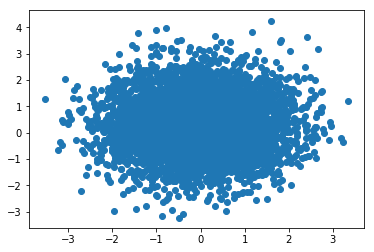

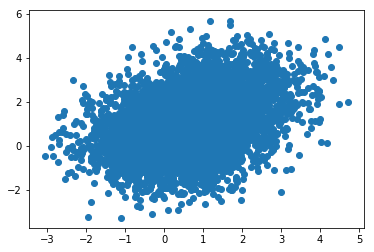

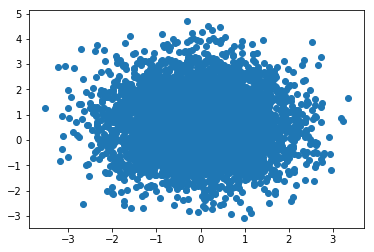

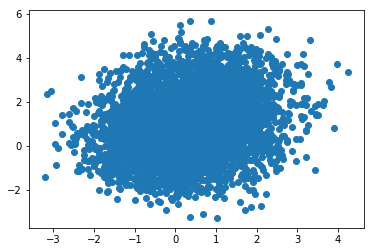

waveform data classified as L 1692
waveform data classified as R 1653
waveform data classified as B 1655
[1 2 0 ..., 2 0 0]
[[-0.69  1.    1.08  1.48]
 [-0.15  0.13  2.27  2.39]
 [-1.45  2.71  3.04  3.21]
 ..., 
 [ 1.18 -0.48  1.81  1.51]
 [ 0.18  1.65  1.91  2.07]
 [ 2.05 -1.99  1.66  2.18]]


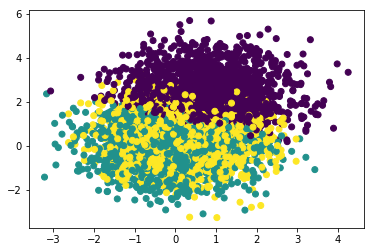

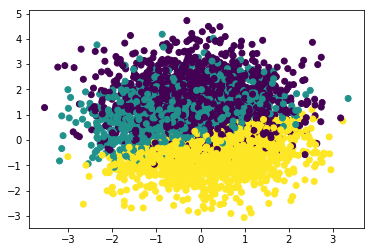

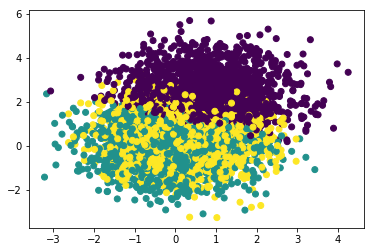

1853 entries were classified in one cluster of which:

Intersection of C1 with R  942
Intersection of C1 with L  840
Intersection of C1  with B  71
************************************* 

1545 entries were classified in one cluster of which:

intersection of C2 with R  403
intersection of C2 with L  428
intersection of C2 with B  714
************************************* 
1602 entries were classified in one cluster of which:

intersection of C3 with R  347
intersection of C3 with L  385
intersection of C3 with B  870


In [81]:
waveform, waveform_meta = arff.loadarff("datasets/waveform.arff")
waveform_data_all = np.array([waveform['x1'], waveform['x2'],
                      waveform['x3'], waveform['x4']]).transpose()
waveform_class = waveform['class'].reshape((len(waveform), 1))

waveform_data=0
waveform_data = waveform_data_all

print len(waveform_data)
print waveform_data.shape

print waveform_data
plt.figure()
plt.scatter(waveform_data_all[:, 0], waveform_data_all[:, 1])
plt.show()
plt.figure()
plt.scatter(waveform_data_all[:, 2], waveform_data_all[:, 3])
plt.show()
plt.figure()
plt.scatter(waveform_data_all[:, 0], waveform_data_all[:, 2])
plt.show()
plt.figure()
plt.scatter(waveform_data_all[:, 1], waveform_data_all[:, 3])
plt.show()
plt.figure()



#print accuracies_ar[:][0]
#plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"Bisecting K-means accuracy")
d_Iris_setosa=waveform_data_all[np.where(waveform["class"]=="0")]
d_Iris_versicolor=waveform_data_all[np.where(waveform["class"]=="1")]
d_Iris_virginica=waveform_data_all[np.where(waveform["class"]=="2")]

print "waveform data classified as L",len(d_Iris_setosa)
print "waveform data classified as R",len(d_Iris_versicolor)
print "waveform data classified as B",len(d_Iris_virginica)


_,cluster_assingment=k_means(3,waveform_data)

print cluster_assingment
results_c1=waveform_data_all[np.where(cluster_assingment[:]==0),:][0]
results_c2=waveform_data_all[np.where(cluster_assingment[:]==1),:][0]
results_c3=waveform_data_all[np.where(cluster_assingment[:]==2),:][0]
print results_c1

plt.figure()
plt.scatter(waveform_data_all[:,1],waveform_data_all[:,3],c=cluster_assingment)
plt.show()
plt.figure()
plt.scatter(waveform_data_all[:,0],waveform_data_all[:,2],c=cluster_assingment)
plt.show()
plt.figure()
plt.scatter(waveform_data_all[:,1],waveform_data_all[:,3],c=cluster_assingment)
plt.show()




print len(results_c1), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, list(results_c1)))
d=len(sett)
print"Intersection of C1 with R ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1 with L ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1  with B ",d

print "************************************* \n"

print len(results_c2), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with R ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with L ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection of C2 with B ",d

print "************************************* "

print len(results_c3), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with R ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with L ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection of C3 with B ",d



In [50]:
print accuracies_ar

[[  5.39921829e-01   5.13303843e+02   5.39921829e-01   5.13303843e+02
    5.39921829e-01   5.13303843e+02   5.39921829e-01   5.13303843e+02
    5.39921829e-01   5.13303843e+02   5.39921829e-01   5.13303843e+02
    5.39921829e-01   5.13303843e+02   5.39921829e-01   5.13303843e+02
    5.39921829e-01   5.13303843e+02]
 [  6.80872428e-01   5.20633406e+02   6.68504721e-01   5.20263779e+02
    6.80872428e-01   5.20633406e+02   6.80872428e-01   5.20633406e+02
    6.80872428e-01   5.20633406e+02   6.80872428e-01   5.20633406e+02
    6.80872428e-01   5.20633406e+02   6.80872428e-01   5.20633406e+02
    6.80872428e-01   5.20633406e+02]
 [  6.21742303e-01   4.27250678e+02   6.21742303e-01   4.27250678e+02
    6.21742303e-01   4.27250678e+02   6.21742303e-01   4.27250678e+02
    6.21742303e-01   4.27250678e+02   6.21742303e-01   4.27250678e+02
    6.21742303e-01   4.27250678e+02   6.21742303e-01   4.27250678e+02
    6.21742303e-01   4.27250678e+02]
 [  4.78257787e-01   3.58433641e+02   6.49941229e

In [77]:
print waveform_meta


Dataset: waveform
	x1's type is numeric
	x2's type is numeric
	x3's type is numeric
	x4's type is numeric
	x5's type is numeric
	x6's type is numeric
	x7's type is numeric
	x8's type is numeric
	x9's type is numeric
	x10's type is numeric
	x11's type is numeric
	x12's type is numeric
	x13's type is numeric
	x14's type is numeric
	x15's type is numeric
	x16's type is numeric
	x17's type is numeric
	x18's type is numeric
	x19's type is numeric
	x20's type is numeric
	x21's type is numeric
	x22's type is numeric
	x23's type is numeric
	x24's type is numeric
	x25's type is numeric
	x26's type is numeric
	x27's type is numeric
	x28's type is numeric
	x29's type is numeric
	x30's type is numeric
	x31's type is numeric
	x32's type is numeric
	x33's type is numeric
	x34's type is numeric
	x35's type is numeric
	x36's type is numeric
	x37's type is numeric
	x38's type is numeric
	x39's type is numeric
	x40's type is numeric
	class's type is nominal, range is ('0', '1', '2')



In [26]:
print balance_data


[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  2.]
 [ 1.  1.  1.  3.]
 ..., 
 [ 5.  5.  5.  3.]
 [ 5.  5.  5.  4.]
 [ 5.  5.  5.  5.]]
